### Load the required libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

### Check for GPU

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


### Choose the transformations on the data

In [10]:
transform = transforms.Compose([
    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(padding=4,padding_mode='reflect'),
    transforms.RandomCrop(size=32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

### Train test split

In [11]:
train_ds = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_ds = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


### Set the values for hyperparameters
* Might require changes after checking the learning rate plot

In [12]:
bs = 256
lr_low = 1e-5
lr_high = 1e-2
wd = 1e-4
Pretrained = True
learning_rate = 0.0001
epochs = 50
momentum = 0.9

### Create iterable object with mini-batches

In [13]:
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False)

### Visualize a Batch of Training Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

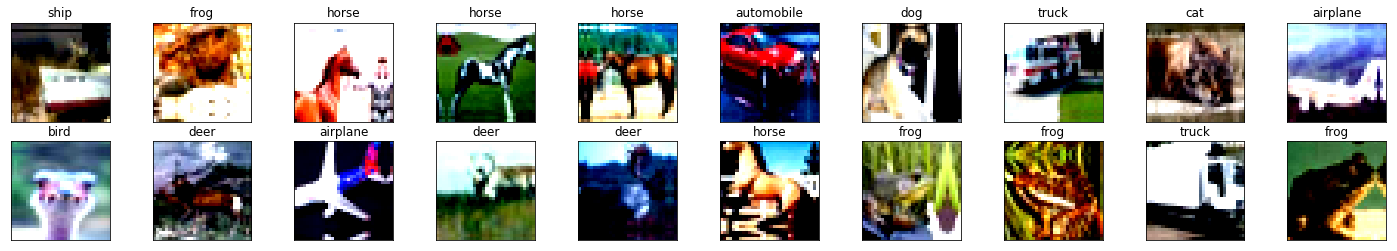

In [14]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


### Check Class imbalance

In [41]:
from collections import defaultdict
classes = defaultdict(int)

classes_list =['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

print('Number of samples in train data %2d \n' % len(train_ds))
for x,y in (train_ds):
    if y not in classes:
        classes[y] = 1
    else: classes[y] = classes[y]+1  
        
for i in range(10):
    print('Class %s : %2d' % (classes_list[i], classes[i]))

Number of samples in train data 50000 

Class airplane : 5000
Class automobile : 5000
Class bird : 5000
Class cat : 5000
Class deer : 5000
Class dog : 5000
Class frog : 5000
Class horse : 5000
Class ship : 5000
Class truck : 5000


### Define Class for the network
Inherit the filters from vgg-16 by setting pretrained = True/False.   
Attach a fully connected layer in the end

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        vgg = models.vgg16(pretrained=Pretrained)
        layers = list(vgg.children())[0][:31]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.linear1 = nn.Linear(512,10)

    def forward(self,x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0],-1)
        x = self.bn1(x)
        x = self.linear1(x)
        return x
    
    

### Instantiate a Class object and move to GPU

In [17]:
net = Net()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    net.cuda()
    

In [100]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9 )

### Helper Functions

In [22]:
def correct(preds, targs):
    preds = torch.max(preds, dim=1)[1]
    return (preds==targs).float().sum()

def get_optimizer(model,momentum=0.9, weight_decay= 1e-4 , lr = 0.0001):
    """
    Initialize optimizer with the learning rate passed
    """
    optim = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum , weight_decay= weight_decay )
    
    return optim

def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))



### Learning Rate Finder
* Choose max_learning rate that is 0.1*learningrate that gives lowest loss

In [23]:
def LR_range_finder(train_on_gpu,model, train_dl,momentum, wd,  lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = "mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, momentum, wd, lr=lrs[ind])
            if train_on_gpu:
                x, y = x.cuda().float(), y.cuda().long()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1     
    load_model(model, str(p))
    return lrs, losses


In [24]:
lrs, losses = LR_range_finder(train_on_gpu,net, train_loader, momentum, wd, lr_low=1e-8, lr_high=0.5)

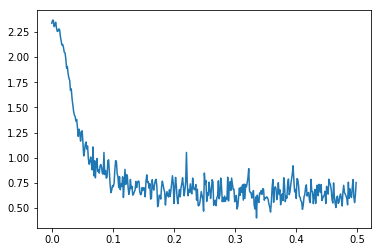

In [25]:
plt.plot(lrs, losses)
plt.show()

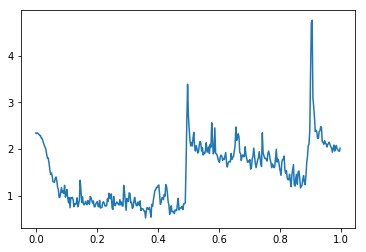

In [26]:
lrs, losses = LR_range_finder(train_on_gpu,net, train_loader, momentum, wd, lr_low=1e-5, lr_high=1)
plt.plot(lrs, losses)
plt.show()

* We see low learning rates at 1e-1 range, so we choose lr_high = 1e-2

### Set Triangular learning rate with one cycle

In [29]:
def get_triangular_lr2(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

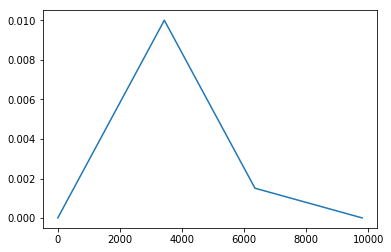

In [30]:
iterations = epochs * len(train_loader)
lrs = get_triangular_lr2(lr_low, lr_high, iterations)
plt.plot(lrs)

### Training the network

In [31]:
def train_triangular_policy(train_on_gpu,model, train_dl, valid_dl,  lr_low=1e-5, lr_high=0.0001,momentum =0.9, wd = 0.0, epochs=4, name = str('temp')):
    idx = 0
    acc = 0
    iterations = epochs * len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        """
        if i % 10 == 0:
            torch.save(model.state_dict(), 'Resnet_1.pth')
            
        """
        for i, (x, y) in enumerate(train_dl):
            # Use the learning rate as per triangular learning rate
            optim = get_optimizer(model, momentum, wd, lr = lrs[idx])
            batch = y.shape[0]
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                x, y = x.cuda().float(), y.cuda().long()
            # forward pass: compute predicted outputs by passing inputs to the model
            out = model(x)
            # calculate the batch loss
            loss = F.cross_entropy(out, y)
            # set the gradients for tensors to zero to prevent gradient accumulation
            optim.zero_grad()
            # backward pass
            loss.backward()
            # Update parameters
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
            

        print("train loss", sum_loss/total)
        # Save the model weights which has lowest validation accuracy
        val_loss, accuracy = val_metrics(train_on_gpu , model, valid_dl)
        if accuracy > acc:
            torch.save(model.state_dict(), name)
        acc = accuracy
            
    return sum_loss/total

In [32]:
def val_metrics(train_on_gpu , model, valid_dl):
    """
    Calculate the accuracy on validation set with weights trained above
    """
    model.eval()
    total = 0
    sum_loss = 0
    total_correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        if train_on_gpu:
            x, y = x.cuda().float(), y.cuda().long()
        out = model(x)
        total_correct += correct(out, y)
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    
    print("val loss and accuracy", sum_loss/total, total_correct/total)
    return (sum_loss/total, total_correct/total)

In [33]:
def val_metrics_new(train_on_gpu , model, valid_dl,batch_size):
    """
    Function that returns class wise accuracy and validation scores
    """
    from sklearn.metrics import classification_report
    # track test loss
    test_loss = 0.0
    total_predictions = []
    total_target = []
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    j = 0
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

    model.eval()
    # iterate over test data
    for data, target in valid_dl:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = F.cross_entropy(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)   
        total_predictions.extend(pred)
        total_target.extend(target.data.view_as(pred))
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct =  np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        j = j+batch_size
        if j > 10000: batch_size = batch_size - (j - 10000)
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
            
    ### Print per class accuracy

    print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    ### Print Fscore
    
    print(classification_report([int(i) for i in total_target], [int(i) for i in total_predictions]))

### Function for training with multiple steps

In [34]:
from datetime import datetime
def training_loop(model, train_dl, valid_dl, steps=1, lr_low=lr_low, lr_high=lr_high,momentum = 0.9, wd = 0.0, epochs=4, name = str('temp')):

    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(train_on_gpu,model, train_dl, valid_dl, lr_low, lr_high,momentum, wd, epochs, name)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [37]:
#training_loop(net, train_loader, test_loader,lr_low = lr_low, lr_high = lr_high, momentum = momentum, wd = wd,epochs=epochs, name = 'temp')
training_loop(net, train_loader, test_loader,lr_low = lr_low, lr_high = lr_high, momentum = momentum, wd = wd,epochs=5, name = 'temp1')

train loss 1.7227490762710571
val loss and accuracy 1.1831904108047486 tensor(0.6309, device='cuda:0')
train loss 0.909462456703186
val loss and accuracy 0.7723348936080933 tensor(0.7371, device='cuda:0')
train loss 0.6739389850997924
val loss and accuracy 0.6657658723831177 tensor(0.7730, device='cuda:0')
train loss 0.6243334159278869
val loss and accuracy 0.6388361826896668 tensor(0.7817, device='cuda:0')
train loss 0.6146983541488648
val loss and accuracy 0.6374888006210327 tensor(0.7820, device='cuda:0')
----End of step Time elapsed 0:05:28.537274


In [39]:
model = Net().cuda()
model.load_state_dict(torch.load('temp1'))

In [40]:
val_metrics(train_on_gpu, model,test_loader)
print('\n')
val_metrics_new(train_on_gpu, model,test_loader,bs)

val loss and accuracy 0.6438950437545776 tensor(0.7786, device='cuda:0')


Test Loss: 0.633185

Test Accuracy of airplane: 80% (804/1000)
Test Accuracy of automobile: 89% (894/1000)
Test Accuracy of  bird: 66% (667/1000)
Test Accuracy of   cat: 64% (640/1000)
Test Accuracy of  deer: 74% (746/1000)
Test Accuracy of   dog: 69% (694/1000)
Test Accuracy of  frog: 85% (850/1000)
Test Accuracy of horse: 78% (788/1000)
Test Accuracy of  ship: 88% (881/1000)
Test Accuracy of truck: 86% (868/1000)

Test Accuracy (Overall): 78.32% (7832/10000)
             precision    recall  f1-score   support

          0       0.80      0.80      0.80      1000
          1       0.86      0.89      0.88      1000
          2       0.75      0.67      0.71      1000
          3       0.65      0.64      0.65      1000
          4       0.72      0.75      0.73      1000
          5       0.72      0.69      0.71      1000
          6       0.82      0.85      0.84      1000
          7       0.77      0.79   